# **MLP - Pima Diabets**

**Context**

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

**Content**

The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

**Acknowledgements**

Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

**Inspiration**

Can you build a machine learning model to accurately predict whether or not the patients in the dataset have diabetes or not?


https://www.kaggle.com/code/vincentlugat/pima-indians-diabetes-eda-prediction-0-906/notebook

## [STEP 01] 라이브러리 및 데이터셋 로딩

In [1]:
# Python libraries
# Classic,data manipulation and linear algebra
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

# Data processing, metrics and modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import DiscriminationThreshold

# Stats
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Time
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

#ignore warning messages
import warnings
warnings.filterwarnings('ignore')

## Read Data

In [2]:
# Google drive mount
from google.colab import drive
drive.mount('/content/drive')

# Set my working directory
import os
os.chdir("/content/drive/MyDrive/Deep Learning/02 MLP")
os.getcwd()

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

data=pd.read_csv('../dataset/dataset_diabetes.csv')

Mounted at /content/drive


## [STEP 02] 데이터 분석

In [3]:
display(data.info(),data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# 2 datasets
D = data[(data['Outcome'] != 0)]
H = data[(data['Outcome'] == 0)]

# Count
def target_count():
    trace = go.Bar( x = data['Outcome'].value_counts().values.tolist(),
                    y = ['healthy', 'diabetic'],
                    orientation = 'h',
                    text = data['Outcome'].value_counts().values.tolist(),
                    textfont = dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8, marker=dict(color=['lightskyblue', 'gold'],
                    line = dict(color='#000000', width=1.5)))

    layout = dict(title = 'Count of outcome variable')
    fig = go.Figure(data = [trace], layout=layout)
    fig.show(renderer='colab')

In [5]:
target_count()

In [6]:
def target_percent():
    trace = go.Pie(labels=['healthy', 'diabetic'], values=data['Outcome'].value_counts(),
                   textfont=dict(size=15), opacity=0.8,
                   marker=dict(colors=['lightskyblue', 'gold'],
                   line=dict(color='#000000', width=1.5)))

    layout = dict(title='Distribution of outcome variable')
    fig = go.Figure(data=[trace], layout=layout)
    fig.show(renderer='colab')

In [7]:
target_percent()

### Missing Values

In [8]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [14]:
data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] \
    = data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

In [15]:
# Define missing plot to detect all missing values in dataset
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,
                       opacity = 0.8, text = percentage_null['Count'],
                       textposition = 'auto',marker=dict(color = '#7EC0EE',
                       line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values (count & %)")
    fig = go.Figure(data = [trace], layout=layout)
    fig.show(renderer='colab')

In [17]:
# Plotting
missing_plot(data, 'Outcome')

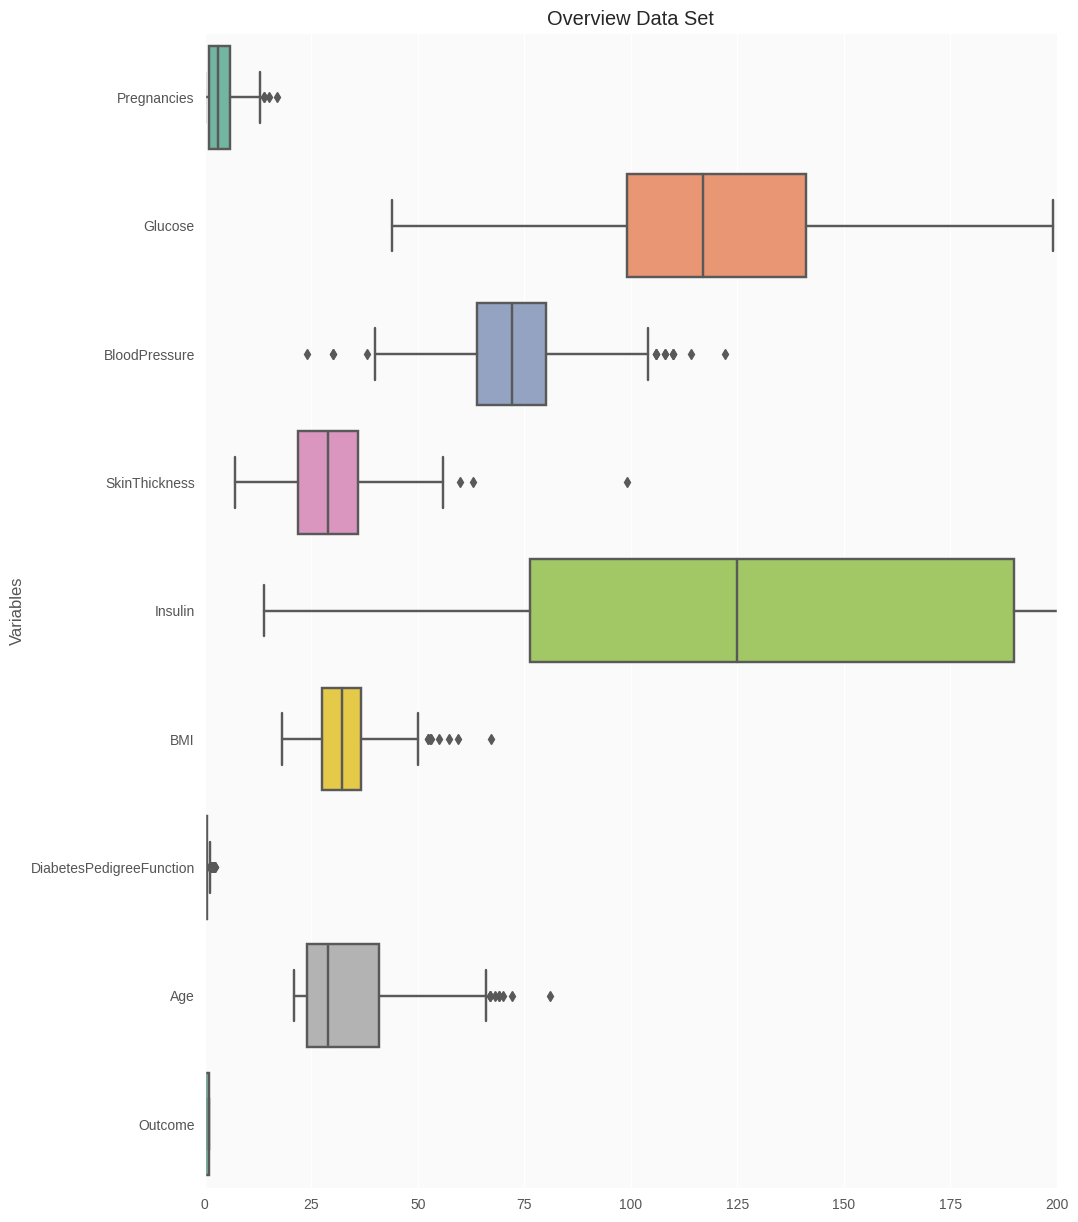

In [19]:
plt.style.use('ggplot')

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title('Overview Data Set')
ax = sns.boxplot(data = data,
  orient = 'h',
  palette = 'Set2')